# Importation des packages

In [23]:
import librosa, librosa.display
import matplotlib.pyplot as plt
import torch as torch
import numpy as np
import soundfile as sf
from torchsummary import summary

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1VJk20mb-W_3sYbz3u6qmiFPquP03Dizc?usp=sharing

In [24]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Importation des données

In [25]:
path_without_noise = "drive/MyDrive/denoising_sound/with_reverb/clean_fileid_44.wav"

Utilisez la fonction `load` de librosa pour importer le son sans bruit.

In [26]:
signal, sr = librosa.load(path_without_noise, sr=22050)

In [27]:
signal.shape

(220500,)

In [28]:
path_with_noise = "drive/MyDrive/denoising_sound/with_reverb_and_noise/clnsp17_birds_413745_3_snr2_tl-23_fileid_44.wav"

Utilisez la fonction `load` de librosa pour importer le son sans bruit.

In [29]:
signal_noise, sr_noise = librosa.load(path_with_noise, sr=22050)

In [30]:
signal_noise.shape

(220500,)

Visualisation des données

Utilisez la fonction `waveshow` de librosa pour afficher les deux signales.

Challenge : utilisez matplotlib pour afficher les graphiques cotes à cotes.

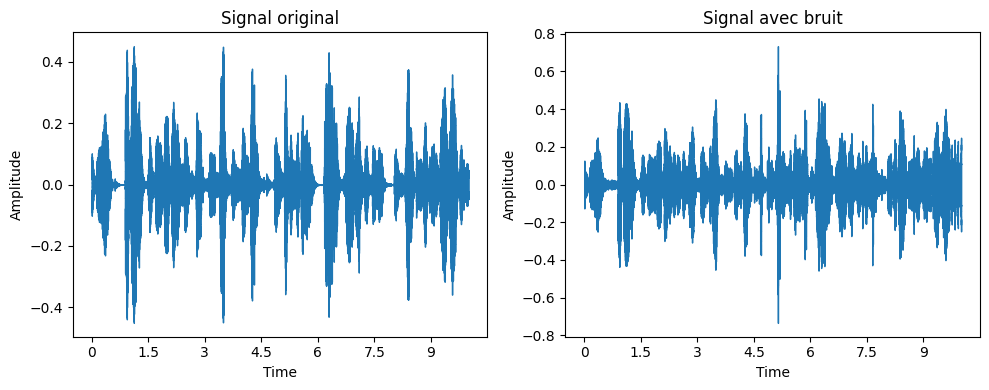

In [31]:
plt.figure(figsize=(10, 4))

# Premier graphique: signal
plt.subplot(1, 2, 1)  # 1 ligne, 2 colonnes, 1er graphique
librosa.display.waveshow(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Signal original")

# Deuxième graphique: signal avec bruit
plt.subplot(1, 2, 2)  # 1 ligne, 2 colonnes, 2ème graphique
librosa.display.waveshow(signal_noise, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Signal avec bruit")

plt.tight_layout()
plt.show()

# Créer le générateur

In [32]:
np.expand_dims(np.expand_dims(signal_noise[:40960], axis=0), axis=1).shape

(1, 1, 40960)

In [33]:
from torch.utils.data import Dataset

In [34]:
class CustomImageDataset(Dataset):
    def __init__(self, x_train, y_train):
        self.img_input = x_train
        self.img_output = y_train

    def __len__(self):
        return len(self.img_output)

    def __getitem__(self, idx):
        image = self.img_input[idx, :, :]
        label = self.img_output[idx, :, :]

        return image, label

In [35]:
x_training = CustomImageDataset(torch.from_numpy(np.expand_dims(np.expand_dims(signal_noise[:40960], axis=0), axis=1)),
                                 torch.from_numpy(np.expand_dims(np.expand_dims(signal[:40960], axis=0), axis=1)))

In [36]:
dataloader_train = torch.utils.data.DataLoader(x_training,
                                                batch_size=1,
                                                shuffle=True)

In [37]:
for x, y in dataloader_train:
  print(x.shape)
  print(y.shape)

  break

torch.Size([1, 1, 40960])
torch.Size([1, 1, 40960])


# Obtenir un sur-entraînement

Vous allez entraîner des modèles pour obtenir un débruitage complet du son bruité.

# fonctions d'entraînement

In [38]:
def step(model:torch.nn.Sequential,
         opt:torch.optim,
         criterion:torch.nn.modules.loss,
         x_train:torch.Tensor,
         y_train:torch.Tensor)->tuple:
  """
  Executes a single training step for a PyTorch model.
  This function performs a forward pass to compute the model's predictions, calculates
  the loss between predictions and actual target values, computes gradients for each
  model parameter, and updates the parameters using the optimizer.

  Args:
      model (torch.nn.Sequential): The PyTorch model to train.
      optimizer (torch.optim.Optimizer): Optimizer used to update the model's parameters.
      criterion (torch.nn.modules.loss._Loss): Loss function used to compute the error.
      x_train (torch.Tensor): Input training data (features).
      y_train (torch.Tensor): Ground truth labels or target values for the training data.
  Returns:
      tuple: The updated model and the computed loss for the current step.
  """

  # Réinitialisez les gradients d'optimizer à zéro avec la méthode 'zero_grad'
  opt.zero_grad()

  # Calculez les prédiction sur le jeu d'entraînement avec la méthode 'froward'
  prediction = model.forward(x_train)

  # Calculez l'erreur de prédiction avec 'criterion'
  loss = criterion(prediction, y_train)

  # Calculez les gradients avec la méthode 'backward'
  loss.backward()

  # Mettre à jour les paramètres du modèle avec la méthode 'step'
  opt.step()

  return model, loss

In [54]:
def fit(model, optimizer, criterion, epoch, trainloader):
    epoch = epoch
    history_train_loss = []

    for e in range(epoch) :

      train_loss_batch = 0

      for images, labels in trainloader:

        # mise à jour des poids avec la fonction 'step'
        model, train_loss = step(model, optimizer, criterion, images, labels)

        train_loss_batch += train_loss.detach().numpy()

      train_loss_batch /= len(trainloader.sampler)

      # Sauvegarde des coûts d'entraînement avec append
      history_train_loss = np.append(history_train_loss, train_loss_batch)

      if e % 100==0:
        print(f'epoch : {e}/{epoch}')
        print('train_loss : '+str(np.squeeze(train_loss_batch)))
        print('-------------------------------------------------------------------------------------------------')

    return model, history_train_loss, history_test_loss

## Première tentative

Initialisation du modèle.

Inspirez-vous de la création du modèle via ce [lien](https://keras.io/examples/vision/oxford_pets_image_segmentation/) pour initialiser le modèle suivant:
- Input layer grâce à la fonction `Input`,
- Une couche de convolution en une dimension avec 64 filtres et un kernel de 5 et une fonction d'activation relu  et avec un padding égal à `same` grâce à la fonction `Conv1D`,
- Une concatenation des couche `input_soud` et `conv1` grâce à la fonction `Concatenate`,
- Une couche de convolution en une dimension avec 1 filtre et un kernel de 3 et avec un padding égal à `same`.

Utilisez enfin la fonction `Model`pour assembler le modèle en prenant exemple sur le lien précédent.


In [40]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # Encodeur (partie descendante)
        self.encoder1 = self.conv_block(in_channels, 16)

        # Couche de réduction de dimension
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Couche du bas (bottleneck)
        self.bottleneck = self.conv_block(16, 32)

        # Décodeur (partie montante)
        self.upconv2 = nn.ConvTranspose1d(32, 16, kernel_size=2, stride=2)


        self.final_layer = nn.Conv1d(32, 1, kernel_size=1, stride=1, padding="same")


    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding="same"),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encodeur
        enc1 = self.encoder1(x)                # Première couche d'encodage
        pool1 = self.pool(enc1)

        # Bottleneck
        bottleneck = self.bottleneck(pool1)

        # Décodeur avec les skip connections
        dec2 = self.upconv2(bottleneck)
        cat2 = torch.cat((dec2, enc1), dim=1)
        output = self.final_layer(cat2)

        return output

# Création de l'instance du modèle et utilisation de torchsummary
model = UNet(in_channels=1, out_channels=1)
summary(model, (1, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 128]              64
              ReLU-2              [-1, 16, 128]               0
         MaxPool1d-3               [-1, 16, 64]               0
            Conv1d-4               [-1, 32, 64]           1,568
              ReLU-5               [-1, 32, 64]               0
   ConvTranspose1d-6              [-1, 16, 128]           1,040
            Conv1d-7               [-1, 1, 128]              33
Total params: 2,705
Trainable params: 2,705
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 0.01
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


In [41]:
model

UNet(
  (encoder1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=same)
    (1): ReLU(inplace=True)
  )
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bottleneck): Sequential(
    (0): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=same)
    (1): ReLU(inplace=True)
  )
  (upconv2): ConvTranspose1d(32, 16, kernel_size=(2,), stride=(2,))
  (final_layer): Conv1d(32, 1, kernel_size=(1,), stride=(1,), padding=same)
)

In [42]:
result = model.forward(torch.randn(1, 1, 128))

In [43]:
result.shape

torch.Size([1, 1, 128])

Initialisez `criterion` avec la fonction `NLLLoss`.

Initialisez `optimizer` avec `Adam` et un learning rate de 0.001.

In [44]:
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [45]:
epoch = 3000

In [55]:
model, history_train_loss, history_test_loss = fit(model,
                                                   optimizer,
                                                   criterion,
                                                   epoch,
                                                   dataloader_train)

epoch : 0/3000
train_loss : 0.006828428711742163
-------------------------------------------------------------------------------------------------
epoch : 100/3000
train_loss : 0.006849094294011593
-------------------------------------------------------------------------------------------------
epoch : 200/3000
train_loss : 0.006907521281391382
-------------------------------------------------------------------------------------------------
epoch : 300/3000
train_loss : 0.006859029643237591
-------------------------------------------------------------------------------------------------


KeyboardInterrupt: 

Utilisez la méthode prédict pour prédire le résultat du modèle à partir de `signal_noise_expand`

In [56]:
np.expand_dims(np.expand_dims(signal_noise[:40960], axis=0), axis=1).shape

(1, 1, 40960)

In [57]:
signal_pred = model.forward(torch.from_numpy(np.expand_dims(np.expand_dims(signal_noise[:40960], axis=0), axis=1)))

In [58]:
signal_pred.shape

torch.Size([1, 1, 40960])

Utilisez la fonction `write` du package `soundfile` pour enregistrer `signal_noise_expand`, `signal_exapnd` et `signal_pred` avec pour nom respectif `reel_1.wav`, `pred_1.wav` et `noise_1.wav`.

In [59]:
sf.write('reel_1.wav', signal[:40960], 22050, 'PCM_24')
sf.write('pred_1.wav', signal_pred[0, 0, :].detach().numpy(), 22050, 'PCM_24')
sf.write('noise_1.wav', signal_noise[:40960], 22050, 'PCM_24')

Ecoutez le résultat afin de voir s'il est satisfaiant.

## Modèle finale

Initialisation du modèle.

Inspirez-vous de la création du modèle via ce [lien](https://keras.io/examples/vision/oxford_pets_image_segmentation/) pour initialiser le modèle suivant:
- Input layer grâce à la fonction `Input`,
- Une couche de convolution en une dimension avec 64 filtres et un kernel de 5 et une fonction d'activation relu  et avec un padding égal à `same` grâce à la fonction `Conv1D`,
- Une couche de max pooling avec la fonction `MaxPooling1d`
- Une couche de convolution en une dimension avec 128 filtres de longueur 5 et une activation relu.
- Une couche de max pooling.
- Une couche de convolution en une dimension avec 256 filtres de longueur 5 et une activation relu.
- Une couche de convolution en une dimension avec 256 filtres de longueur 5 et une activation relu.
- Une couche d'upsampling avec la fonction `UpSampling1D`
- Une concatenation des couche `conv2` et `conv2_up` grâce à la fonction `Concatenate`,
- Une couche d'upsampling avec la fonction `UpSampling1D`
- Une concatenation des couche `conv1` et `conv1_up` grâce à la fonction `Concatenate`,
- Une couche de convolution en une dimension avec 32 filtres de longueur 5 et une activation relu.
- Une concatenation des couche `input_sound` et `conv0_up` grâce à la fonction `Concatenate`,
- Une couche de convolution en une dimension avec 1 filtre et un kernel de 3 et avec un padding égal à `same`.

Utilisez enfin la fonction `Model`pour assembler le modèle en prenant exemple sur le lien précédent.


In [60]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()

        # Encodeur (partie descendante)
        self.encoder1 = self.conv_block(in_channels, 64, kernel_size=5)

        # Couche de réduction de dimension
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)

        # Encodeur (partie descendante)
        self.encoder2 = self.conv_block(64, 128, kernel_size=5)

        # Encodeur (partie descendante)
        self.encoder3 = self.conv_block(128, 256, kernel_size=5)

        # Couche du bas (bottleneck)
        self.bottleneck = self.conv_block(256, 512, kernel_size=5)

        # Décodeur (partie montante)
        self.upconv3 = nn.ConvTranspose1d(512, 256, kernel_size=2, stride=2)

        # Décodeur (partie montante)
        self.upconv2 = nn.ConvTranspose1d(512, 128, kernel_size=2, stride=2)

        # Décodeur (partie montante)
        self.upconv1 = nn.ConvTranspose1d(256, 64, kernel_size=2, stride=2)


        self.final_layer = nn.Conv1d(128, 1, kernel_size=1, stride=1, padding="same")


    def conv_block(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size, padding="same"),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        # Encodeur
        enc1 = self.encoder1(x)
        pool1 = self.pool(enc1)

        enc2 = self.encoder2(pool1)
        pool2 = self.pool(enc2)

        enc3 = self.encoder3(pool2)
        pool3 = self.pool(enc3)

        # Bottleneck
        bottleneck = self.bottleneck(pool3)

        # Décodeur avec les skip connections
        dec3 = self.upconv3(bottleneck)
        cat3 = torch.cat((dec3, enc3), dim=1)

        dec2 = self.upconv2(cat3)
        cat2 = torch.cat((dec2, enc2), dim=1)

        dec1 = self.upconv1(cat2)
        cat1 = torch.cat((dec1, enc1), dim=1)

        output = self.final_layer(cat1)

        return output

# Création de l'instance du modèle et utilisation de torchsummary
model = UNet(in_channels=1, out_channels=1)
summary(model, (1, 128))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 64, 128]             384
              ReLU-2              [-1, 64, 128]               0
         MaxPool1d-3               [-1, 64, 64]               0
            Conv1d-4              [-1, 128, 64]          41,088
              ReLU-5              [-1, 128, 64]               0
         MaxPool1d-6              [-1, 128, 32]               0
            Conv1d-7              [-1, 256, 32]         164,096
              ReLU-8              [-1, 256, 32]               0
         MaxPool1d-9              [-1, 256, 16]               0
           Conv1d-10              [-1, 512, 16]         655,872
             ReLU-11              [-1, 512, 16]               0
  ConvTranspose1d-12              [-1, 256, 32]         262,400
  ConvTranspose1d-13              [-1, 128, 64]         131,200
  ConvTranspose1d-14              [-1, 

Initialisez `criterion` avec la fonction `NLLLoss`.

Initialisez `optimizer` avec `Adam` et un learning rate de 0.001.

In [61]:
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [62]:
epoch = 3000

In [63]:
model, history_train_loss, history_test_loss = fit(model,
                                                   optimizer,
                                                   criterion,
                                                   epoch,
                                                   dataloader_train)

epoch : 0/3000
train_loss : 0.04342130571603775
-------------------------------------------------------------------------------------------------
epoch : 100/3000
train_loss : 0.006528886966407299
-------------------------------------------------------------------------------------------------
epoch : 200/3000
train_loss : 0.005589860957115889
-------------------------------------------------------------------------------------------------
epoch : 300/3000
train_loss : 0.005628318525850773
-------------------------------------------------------------------------------------------------
epoch : 400/3000
train_loss : 0.004740108270198107
-------------------------------------------------------------------------------------------------
epoch : 500/3000
train_loss : 0.004240052308887243
-------------------------------------------------------------------------------------------------
epoch : 600/3000
train_loss : 0.004265152383595705
----------------------------------------------------------

KeyboardInterrupt: 

In [64]:
signal_pred = model.forward(torch.from_numpy(np.expand_dims(np.expand_dims(signal_noise[:40960], axis=0), axis=1)))

Utilisez la fonction `write` du package `soundfile` pour enregistrer `signal_noise_expand`, `signal_exapnd` et `signal_pred` avec pour nom respectif `reel_3.wav`, `pred_3.wav` et `noise_3.wav`.

In [65]:
sf.write('reel_2.wav', signal[:40960], 22050, 'PCM_24')
sf.write('pred_2.wav', signal_pred[0, 0, :].detach().numpy(), 22050, 'PCM_24')
sf.write('noise_2.wav', signal_noise[:40960], 22050, 'PCM_24')

Ecoutez le résultat afin de voir s'il est satisfaiant.